In [43]:
import sys
sys.path.append('..')

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import torch.optim as optim
import torchvision
import torch.nn as nn
import torch.cuda
import torch.utils.data as td
from torchvision.transforms import RandomRotation, RandomResizedCrop, RandomHorizontalFlip, Resize, Normalize

In [45]:
syn_mean = 106.80105799387864
syn_std = 56.62941734142311
act_mean = 0.4290619492530823
act_std = 0.14064496755599976 

In [46]:
import segmentation_models_pytorch as smp


In [47]:
from data_sets import SynData, AngioData

In [48]:
smp.__version__

'0.3.2'

In [49]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [50]:
#train_val_test_split_probs = [0.5, 0.25, 0.25]
syn_data_path = r"C:\Users\nugni\OneDrive\Skrivebord\Bachelor\Bachelor_rep_angiograms\src\syn_data"
data_path = r"C:\Users\nugni\OneDrive\Skrivebord\Bachelor\local_data\data\Data"
transformations = [
    RandomRotation(degrees=(-10, 10)), 
    RandomResizedCrop(size=(736, 736), scale=(0.7, 1), ratio=(0.9, 1.1)),
    RandomHorizontalFlip(p=0.5), 
    Resize(size=(736, 736))
]
syn_norm = [Normalize(mean=syn_mean, std=syn_std)]
act_norm = [Normalize(mean=act_mean, std=act_std)]

Make data set, and split

In [51]:
#SynDataSet = SynData(syn_data_path + "/syn_input", syn_data_path + "/syn_label",transforms_train=syn_norm)
syn_train = SynData(syn_data_path + "/train/input", syn_data_path + "/train/label",transforms_train=syn_norm)#, syn_val, syn_test = td.random_split(SynDataSet, train_val_test_split_probs)
syn_val = SynData(syn_data_path + "/val/input", syn_data_path + "/val/label",transforms_train=syn_norm)
syn_test = SynData(syn_data_path + "/test/input", syn_data_path + "/test/label",transforms_train=syn_norm)

DataSet1 = AngioData(data_path + r"\ImsegmentedPt_02 V_1\Orig", data_path + r"\ImsegmentedPt_02 V_1\manual", transforms_train=act_norm, transforms_both=transformations)
DataSet3 = AngioData(data_path + r"\ImsegmentedPt_02 V_3\Orig", data_path + r"\ImsegmentedPt_02 V_3\manual", transforms_train=act_norm, transforms_both=transformations)
DataSet4 = AngioData(data_path + r"\ImsegmentedPt_02 V_4\Orig", data_path + r"\ImsegmentedPt_02 V_4\Orig",transforms_train=act_norm, transforms_both=transformations)
DataSet6 = AngioData(data_path + r"\ImsegmentedPt_02 V_6\Orig", data_path + r"\ImsegmentedPt_02 V_6\Annotations",transforms_train=act_norm, transforms_both=transformations)
DataSet7 = AngioData(data_path + r"\ImsegmentedPt_02 V_7\Orig", data_path + r"\ImsegmentedPt_02 V_7\Annotations",transforms_train=act_norm, transforms_both=transformations)
DataSet8 = AngioData(data_path + r"\ImsegmentedPt_02 V_8\Orig", data_path + r"\ImsegmentedPt_02 V_8\Annotations",transforms_train=act_norm, transforms_both=transformations)
#DataSetFull = td.ConcatDataset([DataSet1, DataSet4, DataSet6, DataSet7, DataSet8])

In [52]:
model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=1,
    classes=1
)

In [53]:
for param in model.parameters():
    param.requires_grad = False

for param in model.decoder.parameters():
    param.requires_grad = True

for param in model.encoder.layer4.parameters():
    param.requires_grad = True

In [54]:
#train: 3, 4, 6, val: 7, 8, test: 1
act_train, act_val, act_test = td.ConcatDataset([DataSet3, DataSet4, DataSet6]), td.ConcatDataset([DataSet7, DataSet8]), DataSet1

syn_train_loader = td.DataLoader(syn_train, batch_size=4)
syn_val_loader = td.DataLoader(syn_val)
syn_test_loader = td.DataLoader(syn_test)

act_train_loader = td.DataLoader(act_train)
act_val_loader = td.DataLoader(act_val)
act_test_loader = td.DataLoader(act_test, shuffle=True)

In [55]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)


loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 50

earlyStopper = EarlyStopper(patience=3, min_delta=0.001)


cuda:0


In [56]:
losses = []
val_losses = []
for epoch in range(1, epochs+1):  # loop over the dataset multiple times
    print("Epoch:", epoch)
    pbar = tqdm(syn_train_loader)
    run_losses = []
    run_val_losses = []
    model.train()
    for idx, batch in enumerate(pbar):
        # get the inputs;
        pixel_values, labels = batch

        #transfer data to device, e.g. GPU
        pixel_values, labels = pixel_values.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        predicted = model(pixel_values.float()) #Should not do anything bad
        
        #prob = output.sigmoid()
        #predicted = (prob > 0.5).float()
        
        #mask = (labels != 255) # we don't include the background class in the accuracy calculation
        #pred_labels = predicted.detach().cpu().numpy()
        #true_labels = labels.detach().cpu().numpy()

        #accuracy = accuracy_score(pred_labels, true_labels)
        loss = loss_fn(predicted, labels.float())
        #accuracies.append(accuracy)
        run_losses.append(loss.item())
        #pbar.set_postfix({'Batch': idx, 'Pixel-wise accuracy': sum(accuracies)/len(accuracies), 'Loss': sum(losses)/len(losses)})
        #if idx % 10 == 0:
        #    print(loss.item())
        # backward + optimize
        loss.backward()
        optimizer.step()
    else:
        model.eval()
        with torch.no_grad():
            for idx, batch2 in enumerate(syn_val_loader):
                pixel_values, labels = batch2

                #transfer data to device, e.g. GPU
                pixel_values, labels = pixel_values.to(device), labels.to(device)

                predicted = model(pixel_values.float())
    
                #prob = outputs2.sigmoid()
                #predicted = (prob > 0.5).float()

                #mask = (labels != 255) # we don't include the background class in the accuracy calculation
                #pred_labels = predicted.detach().cpu().numpy()
                #true_labels = labels.detach().cpu().numpy()
                #accuracy = accuracy_score(pred_labels, true_labels)
                val_loss = loss_fn(predicted, labels.float())
                #val_accuracies.append(accuracy)
                run_val_losses.append(val_loss.item())
    losses.append(sum(run_losses)/len(run_losses))
    val_losses.append(sum(run_val_losses)/len(run_val_losses))
    print(f"Train Loss: {losses[epoch-1]}\
         Val Loss: {val_losses[epoch-1]}") #Tog 10 min før
    if earlyStopper.early_stop(val_losses[epoch-1]):
        break

Epoch: 1


100%|██████████| 300/300 [02:40<00:00,  1.87it/s]


Train Loss: 0.47299430807431536         Val Loss: 0.38286286786198614
Epoch: 2


100%|██████████| 300/300 [02:39<00:00,  1.88it/s]


Train Loss: 0.2833371571699778         Val Loss: 0.25781166821718215
Epoch: 3


100%|██████████| 300/300 [02:39<00:00,  1.88it/s]


Train Loss: 0.18881068329016368         Val Loss: 0.19157476589083672
Epoch: 4


100%|██████████| 300/300 [02:39<00:00,  1.88it/s]


Train Loss: 0.14764291803042093         Val Loss: 0.1610654580593109
Epoch: 5


100%|██████████| 300/300 [02:40<00:00,  1.87it/s]


Train Loss: 0.12782818456490835         Val Loss: 0.14751312911510467
Epoch: 6


100%|██████████| 300/300 [02:39<00:00,  1.88it/s]


Train Loss: 0.1169115932782491         Val Loss: 0.14277480006217957
Epoch: 7


100%|██████████| 300/300 [02:39<00:00,  1.88it/s]


Train Loss: 0.10946355362733205         Val Loss: 0.13238359481096268
Epoch: 8


100%|██████████| 300/300 [02:39<00:00,  1.88it/s]


Train Loss: 0.10347832222779592         Val Loss: 0.12692333415150642
Epoch: 9


100%|██████████| 300/300 [02:40<00:00,  1.87it/s]


Train Loss: 0.09881563405195871         Val Loss: 0.1235300573706627
Epoch: 10


100%|██████████| 300/300 [02:39<00:00,  1.88it/s]


Train Loss: 0.09675101717313131         Val Loss: 0.12157216027379036
Epoch: 11


100%|██████████| 300/300 [02:40<00:00,  1.87it/s]


Train Loss: 0.09462649683157603         Val Loss: 0.11953623846173286
Epoch: 12


100%|██████████| 300/300 [02:39<00:00,  1.88it/s]


Train Loss: 0.09233875195185344         Val Loss: 0.11879054367542267
Epoch: 13


100%|██████████| 300/300 [02:39<00:00,  1.88it/s]


Train Loss: 0.09009006520112356         Val Loss: 0.11734243035316468
Epoch: 14


100%|██████████| 300/300 [02:40<00:00,  1.87it/s]


Train Loss: 0.08821803689002991         Val Loss: 0.1157856185734272
Epoch: 15


100%|██████████| 300/300 [02:39<00:00,  1.88it/s]


Train Loss: 0.08727707266807556         Val Loss: 0.1173873083293438
Epoch: 16


100%|██████████| 300/300 [02:39<00:00,  1.88it/s]


Train Loss: 0.0868243290980657         Val Loss: 0.11758606880903244
Epoch: 17


100%|██████████| 300/300 [02:40<00:00,  1.87it/s]


Train Loss: 0.08467710375785828         Val Loss: 0.11692720264196396


In [57]:
#model.load_state_dict(torch.load((r"C:\Users\nugni\OneDrive\Skrivebord\Bachelor\Bachelor_rep_angiograms\src\saved_models/Unet_resnet50_synpretrain")))

In [58]:
torch.save(model.state_dict(), (r"C:\Users\nugni\OneDrive\Skrivebord\Bachelor\Bachelor_rep_angiograms\src\saved_models/Unet_resnet50_synpretrain"))

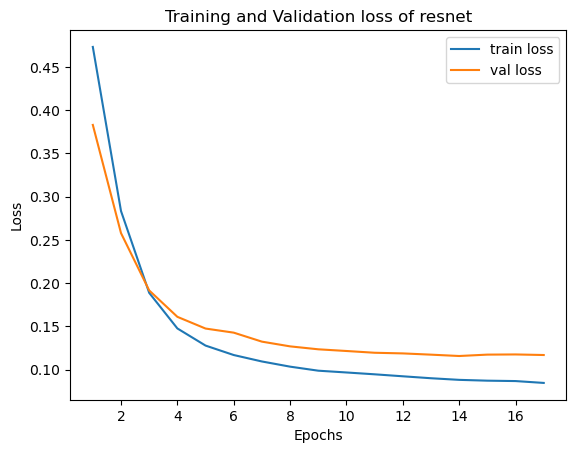

In [59]:
plt.plot(np.arange(len(losses))+1, losses, '-', label="train loss")
plt.plot(np.arange(len(losses))+1, val_losses, '-', label = "val loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Training and Validation loss of resnet")
plt.legend()
plt.show()

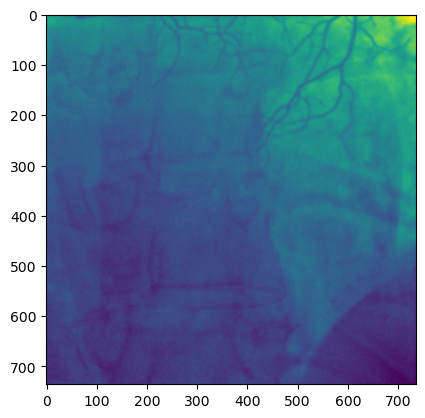

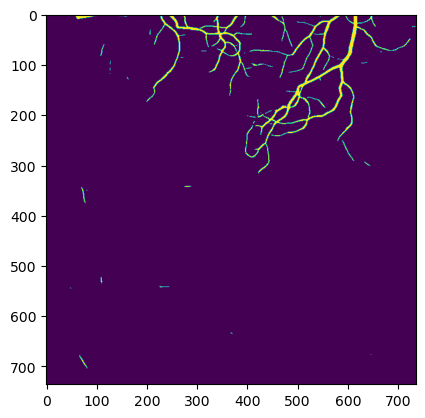

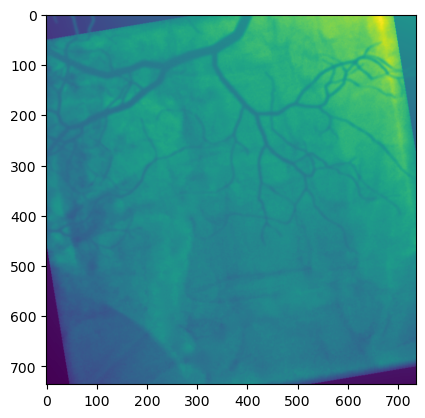

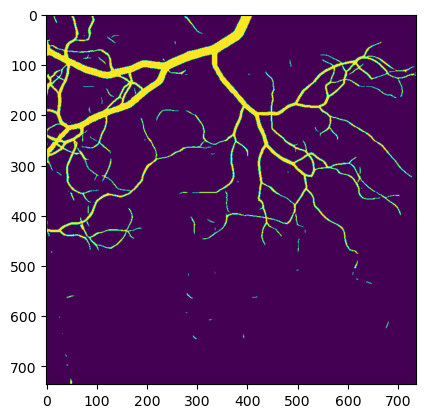

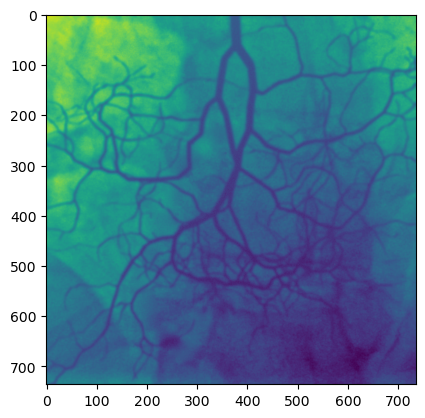

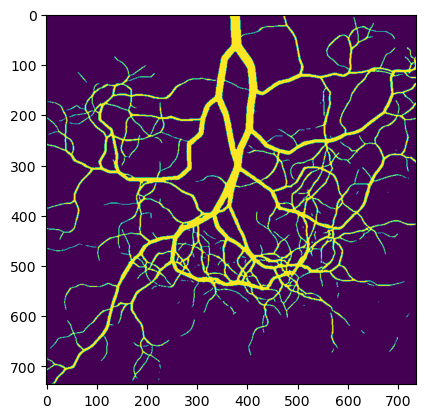

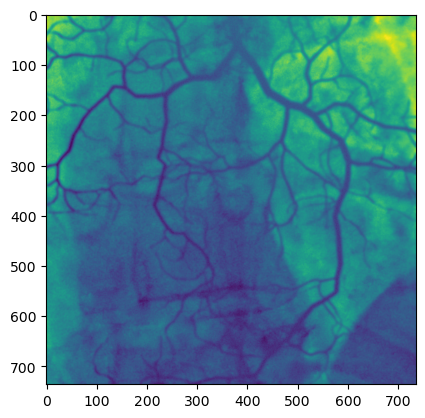

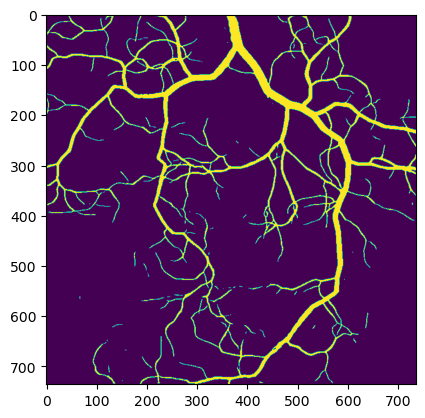

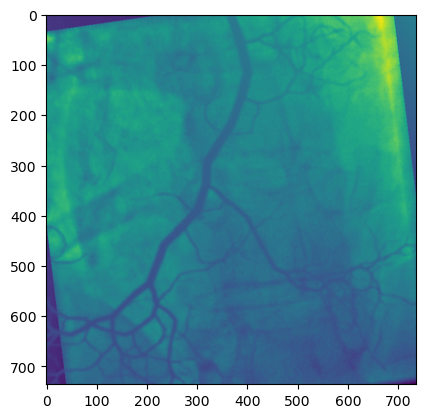

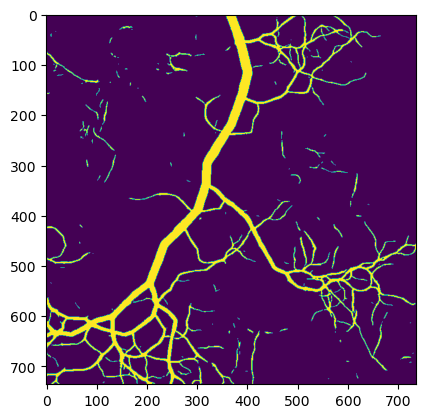

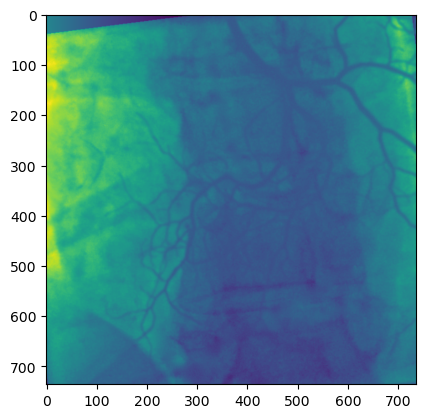

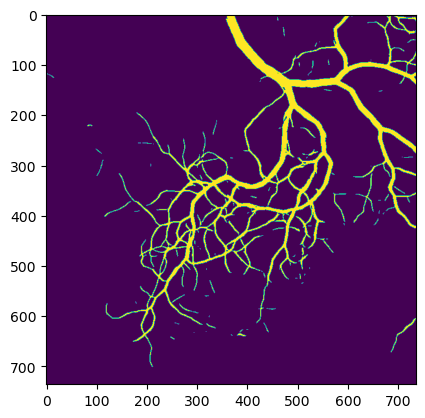

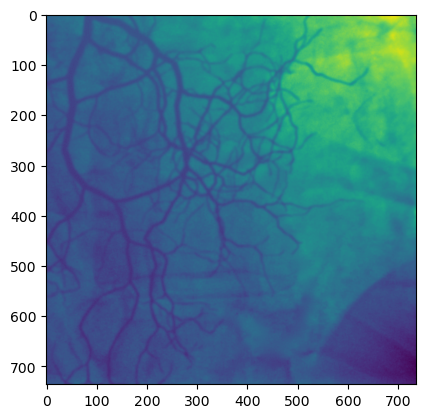

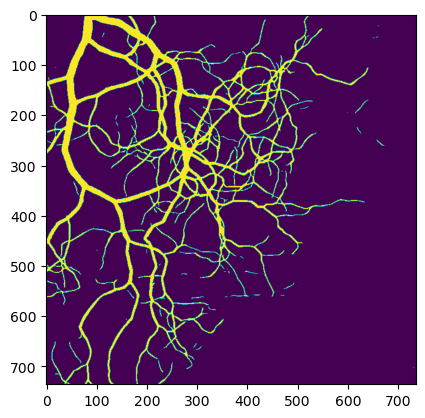

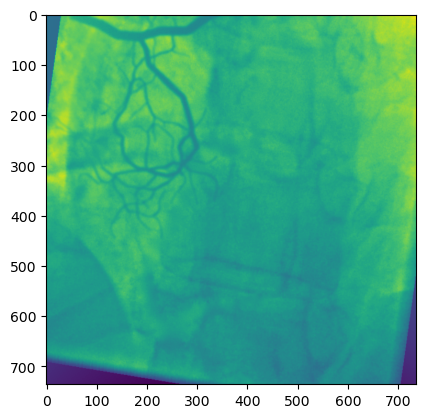

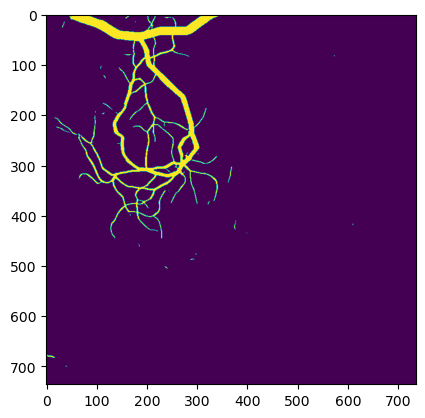

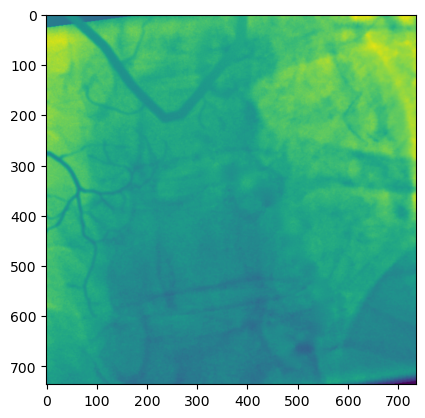

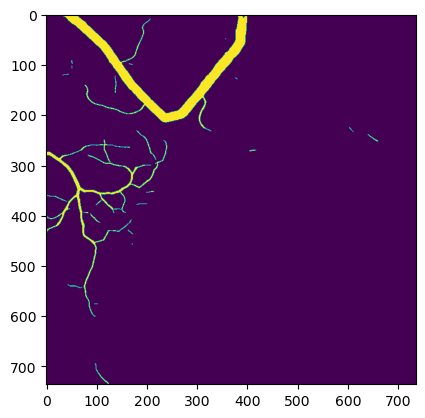

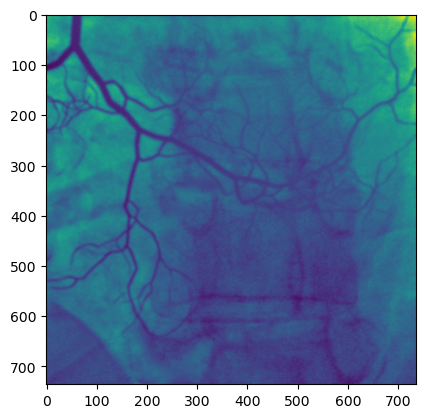

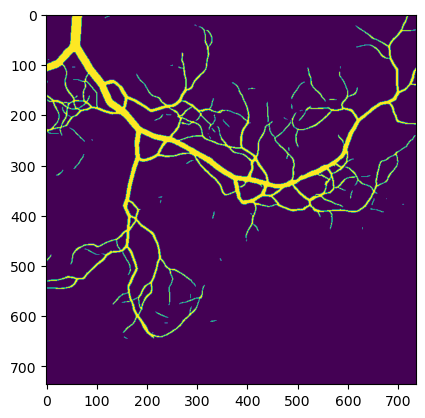

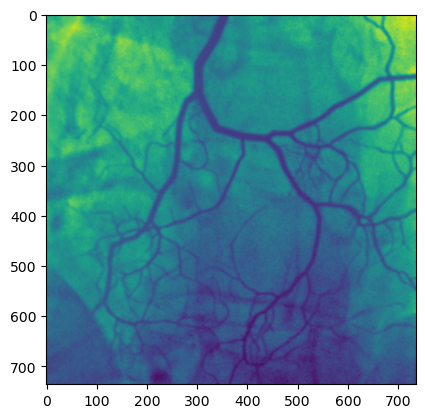

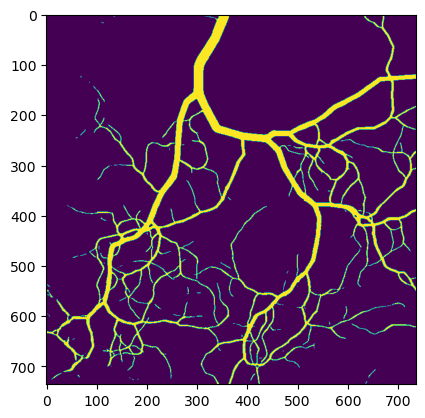

In [60]:
#syn_loader = td.DataLoader(syn_test)
#iter_syn = iter(syn_loader)

for idx, batch2 in enumerate(syn_test_loader):
        img, labels = batch2
        pred = model(img.to(device).float())
        plt.imshow(img.numpy()[0][0])
        plt.show()
        pred = pred.sigmoid()
        pred = (pred > 0.9).float()
        plt.imshow(pred.detach().cpu().numpy()[0][0])
        plt.show()
        if idx == 10:
                break

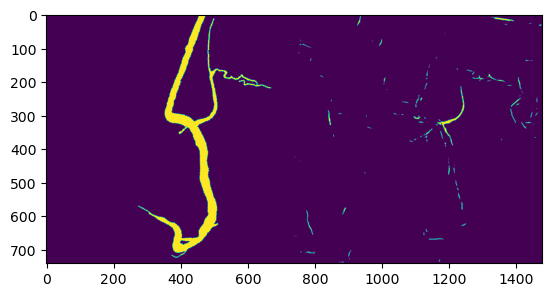

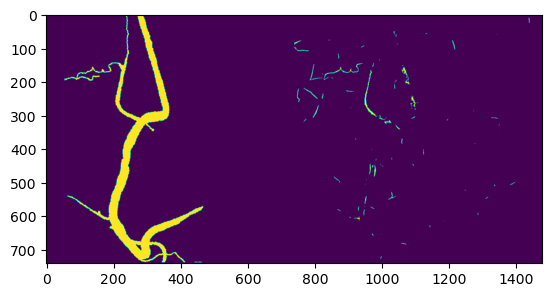

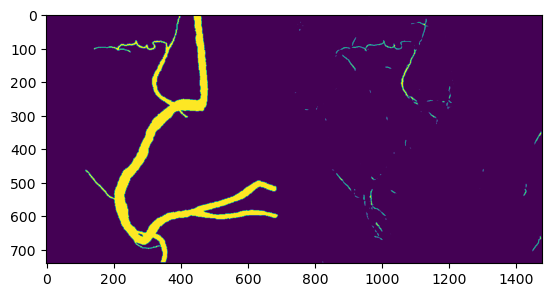

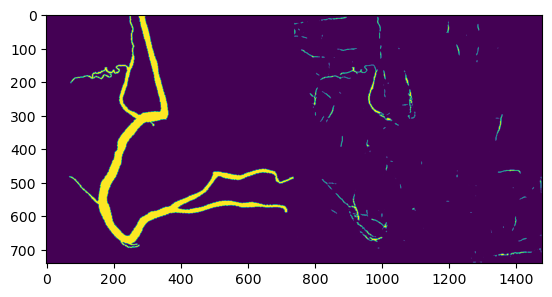

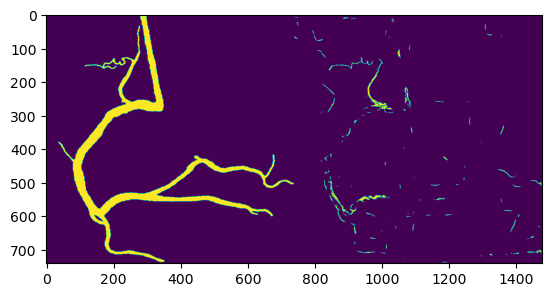

In [61]:
act_loader = td.DataLoader(act_test)
iter_act = iter(act_loader)

for i in range(5):
    img, lab = next(iter_act)
    pred = model(img.to(device).float())
    pred = pred.sigmoid()
    predlab = torch.cat((lab, pred.detach().cpu()), dim=0)
    grid = torchvision.utils.make_grid(predlab)
    plt.imshow(grid.numpy()[0])
    plt.show()

In [62]:
model2 = smp.Unet(
    encoder_name="mit_b3",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
)

In [63]:
for param in model2.parameters():
    param.requires_grad = False

for param in model2.decoder.parameters():
    param.requires_grad = True

for param in model2.encoder.block4.parameters():
    param.requires_grad = True

In [64]:
#SynDataSet = SynData(syn_data_path + "/syn_input", syn_data_path + "/syn_label",transforms_train=syn_norm)
syn_train = SynData(syn_data_path + "/train/input", syn_data_path + "/train/label",transforms_train=syn_norm, repeat_channels=True)#, syn_val, syn_test = td.random_split(SynDataSet, train_val_test_split_probs)
syn_val = SynData(syn_data_path + "/val/input", syn_data_path + "/val/label",transforms_train=syn_norm,repeat_channels=True)
syn_test = SynData(syn_data_path + "/test/input", syn_data_path + "/test/label",transforms_train=syn_norm, repeat_channels=True)

DataSet1 = AngioData(data_path + r"\ImsegmentedPt_02 V_1\Orig", data_path + r"\ImsegmentedPt_02 V_1\manual", transforms_train=act_norm, transforms_both=transformations, repeat_channels=True)
DataSet3 = AngioData(data_path + r"\ImsegmentedPt_02 V_3\Orig", data_path + r"\ImsegmentedPt_02 V_3\manual", transforms_train=act_norm, transforms_both=transformations, repeat_channels=True)
DataSet4 = AngioData(data_path + r"\ImsegmentedPt_02 V_4\Orig", data_path + r"\ImsegmentedPt_02 V_4\Orig",transforms_train=act_norm, transforms_both=transformations, repeat_channels=True)
DataSet6 = AngioData(data_path + r"\ImsegmentedPt_02 V_6\Orig", data_path + r"\ImsegmentedPt_02 V_6\Annotations",transforms_train=act_norm, transforms_both=transformations, repeat_channels=True)
DataSet7 = AngioData(data_path + r"\ImsegmentedPt_02 V_7\Orig", data_path + r"\ImsegmentedPt_02 V_7\Annotations",transforms_train=act_norm, transforms_both=transformations, repeat_channels=True)
DataSet8 = AngioData(data_path + r"\ImsegmentedPt_02 V_8\Orig", data_path + r"\ImsegmentedPt_02 V_8\Annotations",transforms_train=act_norm, transforms_both=transformations, repeat_channels=True)

In [65]:
#train: 3, 4, 6, val: 7, 8, test: 1
act_train, act_val, act_test = td.ConcatDataset([DataSet3, DataSet4, DataSet6]), td.ConcatDataset([DataSet7, DataSet8]), DataSet1

syn_train_loader = td.DataLoader(syn_train, batch_size=4)
syn_val_loader = td.DataLoader(syn_val)
syn_test_loader = td.DataLoader(syn_test)

act_train_loader = td.DataLoader(act_train)
act_val_loader = td.DataLoader(act_val)
act_test_loader = td.DataLoader(act_test, shuffle=True)

In [66]:
model2.to(device)

loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
optimizer = optim.Adam(model2.parameters(), lr=0.001)
epochs = 50

earlyStopper2 = EarlyStopper(patience=2, min_delta=0.001)

In [67]:
losses = []
val_losses = []
for epoch in range(1, epochs+1):  # loop over the dataset multiple times
    print("Epoch:", epoch)
    pbar = tqdm(syn_train_loader)
    run_losses = []#0.0
    run_val_losses = []#0.0
    model2.train()
    for idx, batch in enumerate(pbar):
        # get the inputs;
        pixel_values, labels = batch

        #transfer data to device, e.g. GPU
        pixel_values, labels = pixel_values.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        predicted = model2(pixel_values.float()) #Should not do anything bad
        
        #prob = output.sigmoid()
        #predicted = (prob > 0.5).float()
        
        #mask = (labels != 255) # we don't include the background class in the accuracy calculation
        #pred_labels = predicted.detach().cpu().numpy()
        #true_labels = labels.detach().cpu().numpy()

        #accuracy = accuracy_score(pred_labels, true_labels)
        loss = loss_fn(predicted, labels.float())
        #accuracies.append(accuracy)
        run_losses.append(loss.item())
        #pbar.set_postfix({'Batch': idx, 'Pixel-wise accuracy': sum(accuracies)/len(accuracies), 'Loss': sum(losses)/len(losses)})
        
        # backward + optimize
        loss.backward()
        optimizer.step()
    else:
        model2.eval()
        with torch.no_grad():
            for idx, batch2 in enumerate(syn_val_loader):
                pixel_values, labels = batch2

                #transfer data to device, e.g. GPU
                pixel_values, labels = pixel_values.to(device), labels.to(device)

                predicted = model2(pixel_values.float())
    
                #prob = outputs2.sigmoid()
                #predicted = (prob > 0.5).float()

                #mask = (labels != 255) # we don't include the background class in the accuracy calculation
                #pred_labels = predicted.detach().cpu().numpy()
                #true_labels = labels.detach().cpu().numpy()
                #accuracy = accuracy_score(pred_labels, true_labels)
                val_loss = loss_fn(predicted, labels.float())
                #val_accuracies.append(accuracy)
                run_val_losses.append(val_loss.item())
    losses.append(sum(run_losses)/len(run_losses))
    val_losses.append(sum(run_val_losses)/len(run_val_losses))
    print(f"Train Loss: {losses[epoch-1]}\
         Val Loss: {val_losses[epoch-1]}") #Tog 10 min før
    if earlyStopper2.early_stop(val_losses[epoch-1]):
        break

Epoch: 1


100%|██████████| 300/300 [03:16<00:00,  1.52it/s]


Train Loss: 0.6263890333970388         Val Loss: 0.5571720957756042
Epoch: 2


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Train Loss: 0.4707676160335541         Val Loss: 0.41699264600872993
Epoch: 3


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Train Loss: 0.3374195222059886         Val Loss: 0.3036729867756367
Epoch: 4


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Train Loss: 0.24763435761133828         Val Loss: 0.23567149117588998
Epoch: 5


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Train Loss: 0.19438931345939636         Val Loss: 0.2035393212735653
Epoch: 6


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Train Loss: 0.16169383068879445         Val Loss: 0.17109491243958475
Epoch: 7


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Train Loss: 0.1412449343999227         Val Loss: 0.1590045602619648
Epoch: 8


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Train Loss: 0.12739201426506042         Val Loss: 0.14302630215883255
Epoch: 9


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Train Loss: 0.11764407495657603         Val Loss: 0.13458261668682098
Epoch: 10


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Train Loss: 0.11070396025975546         Val Loss: 0.1274419391155243
Epoch: 11


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Train Loss: 0.10539028207461039         Val Loss: 0.12281287536025047
Epoch: 12


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Train Loss: 0.10074038525422414         Val Loss: 0.11787926226854324
Epoch: 13


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Train Loss: 0.09744234303633371         Val Loss: 0.11766129493713379
Epoch: 14


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Train Loss: 0.09515258034070333         Val Loss: 0.11606978014111519
Epoch: 15


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Train Loss: 0.09292127907276154         Val Loss: 0.11756940975785256
Epoch: 16


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Train Loss: 0.09081954340140025         Val Loss: 0.11556990996003151
Epoch: 17


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Train Loss: 0.0890694397687912         Val Loss: 0.1116219401359558
Epoch: 18


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Train Loss: 0.08739070057868957         Val Loss: 0.11535801231861115
Epoch: 19


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Train Loss: 0.08609761655330658         Val Loss: 0.10993950337171554
Epoch: 20


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Train Loss: 0.08491012990474701         Val Loss: 0.10977687045931817
Epoch: 21


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Train Loss: 0.0842128837108612         Val Loss: 0.10833752378821374
Epoch: 22


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Train Loss: 0.08268217245737712         Val Loss: 0.10689278453588485
Epoch: 23


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Train Loss: 0.08242995818456014         Val Loss: 0.10433714240789413
Epoch: 24


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Train Loss: 0.0816021865606308         Val Loss: 0.10366565182805061
Epoch: 25


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Train Loss: 0.08082750697930653         Val Loss: 0.10327973172068595
Epoch: 26


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Train Loss: 0.07970784862836201         Val Loss: 0.10305749535560609
Epoch: 27


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Train Loss: 0.07917129854361216         Val Loss: 0.10237742468714714
Epoch: 28


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Train Loss: 0.07923196693261464         Val Loss: 0.10269553884863854
Epoch: 29


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Train Loss: 0.07852898180484771         Val Loss: 0.10278547957539558
Epoch: 30


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Train Loss: 0.07736232896645864         Val Loss: 0.10211650013923645
Epoch: 31


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Train Loss: 0.07725133756796519         Val Loss: 0.10170398965477943
Epoch: 32


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Train Loss: 0.0766790364185969         Val Loss: 0.10240339696407318
Epoch: 33


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Train Loss: 0.07648454109827678         Val Loss: 0.10223749652504921
Epoch: 34


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Train Loss: 0.07565882166226705         Val Loss: 0.10146226555109024
Epoch: 35


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Train Loss: 0.07564126729965209         Val Loss: 0.10227740153670312
Epoch: 36


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Train Loss: 0.07532111545403798         Val Loss: 0.10200278893113136
Epoch: 37


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Train Loss: 0.07514773468176524         Val Loss: 0.10111663430929184
Epoch: 38


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Train Loss: 0.07486098945140839         Val Loss: 0.10153797149658203
Epoch: 39


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Train Loss: 0.07400929768880209         Val Loss: 0.10161702126264573
Epoch: 40


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Train Loss: 0.07401613314946492         Val Loss: 0.10226397007703782
Epoch: 41


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Train Loss: 0.07353024780750275         Val Loss: 0.10208529114723205
Epoch: 42


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Train Loss: 0.07314359426498412         Val Loss: 0.10184583336114883
Epoch: 43


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Train Loss: 0.07270048916339875         Val Loss: 0.10214931458234787


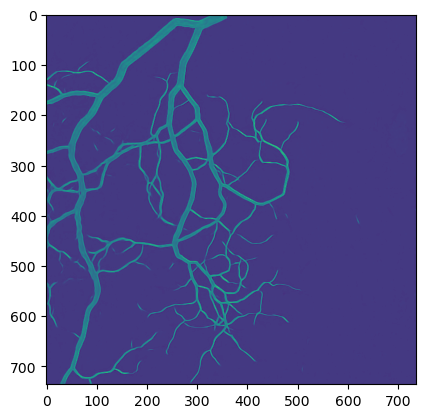

In [68]:
plt.imshow(predicted.detach().cpu().numpy()[0][0]) #lowest: 0.132

In [74]:
torch.save(model2.state_dict(), (r"C:\Users\nugni\OneDrive\Skrivebord\Bachelor\Bachelor_rep_angiograms\src\saved_models/Unet_mit-b3_synpretrain"))

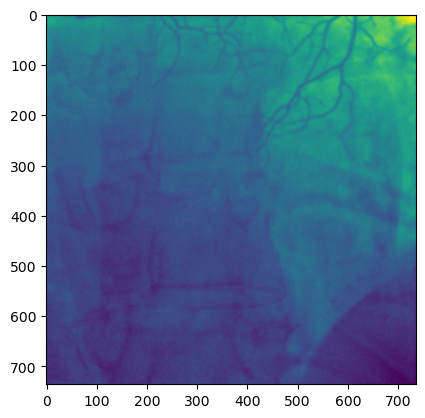

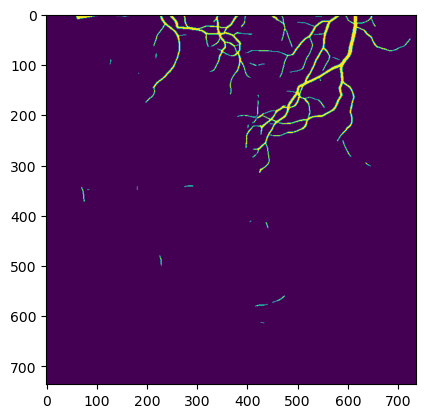

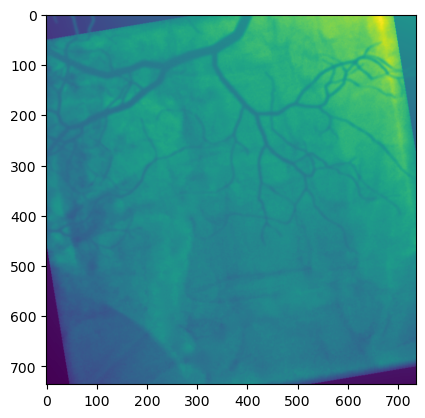

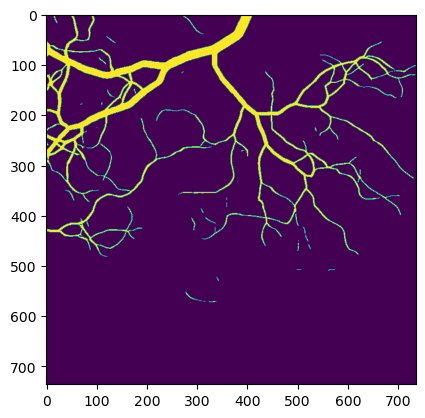

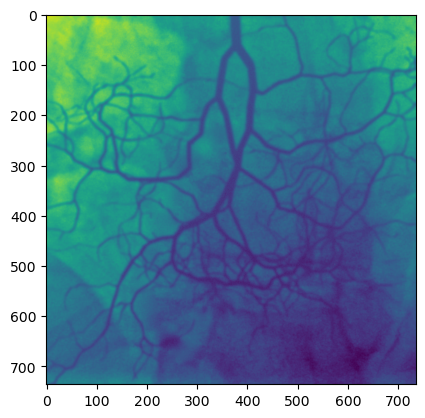

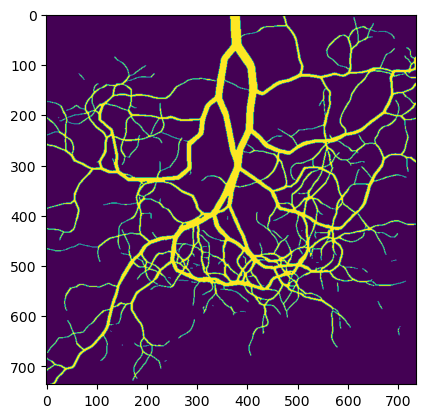

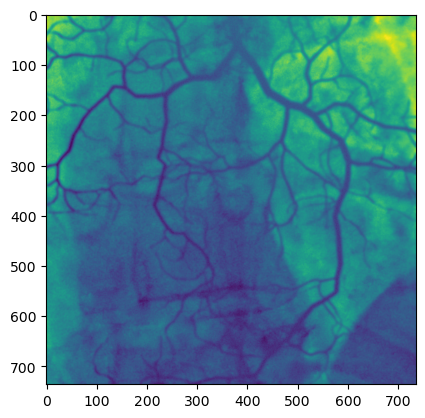

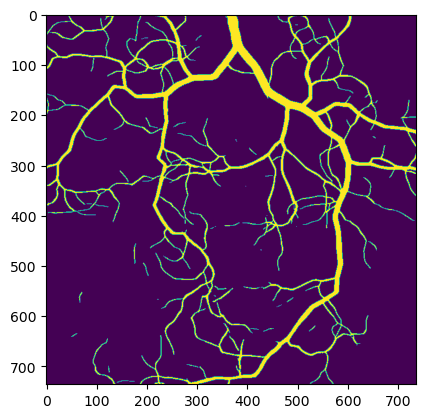

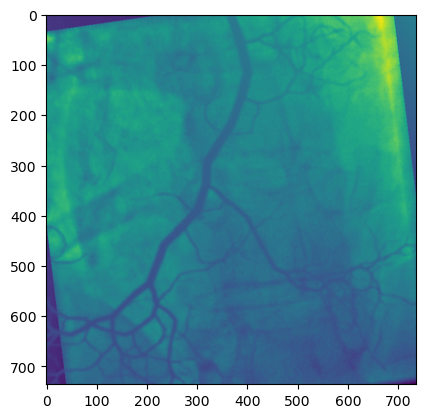

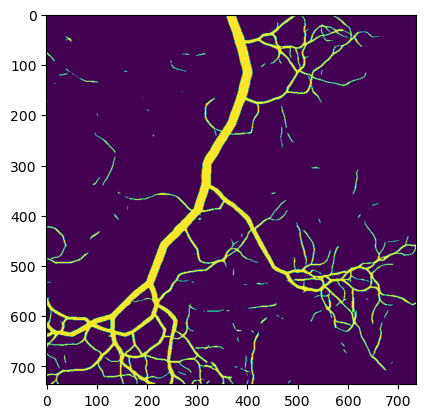

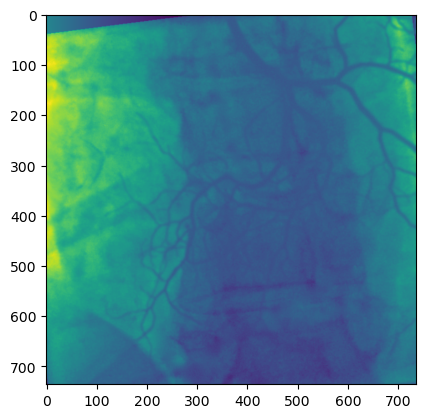

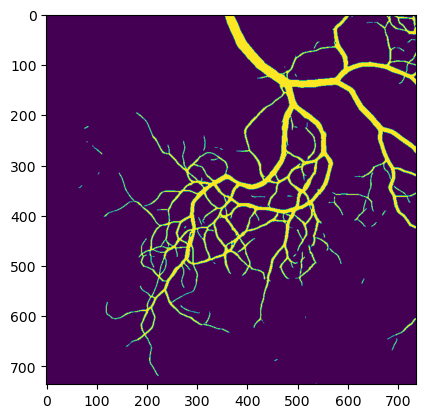

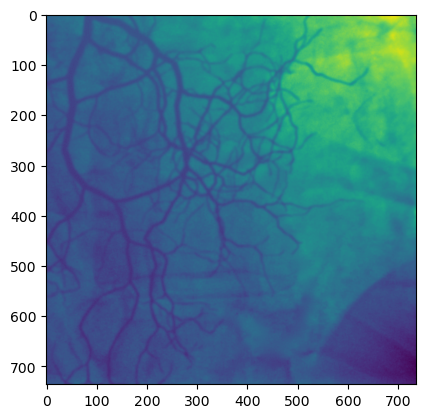

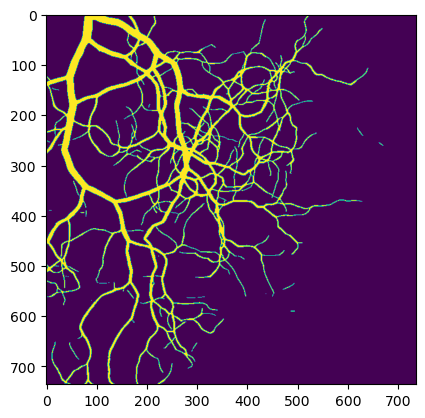

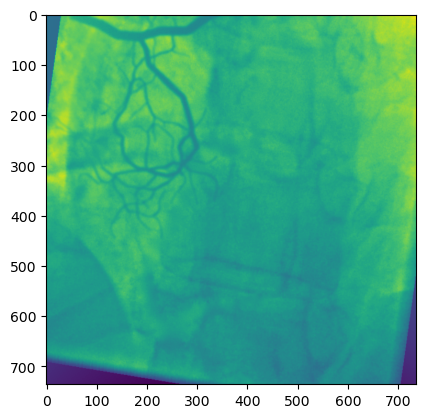

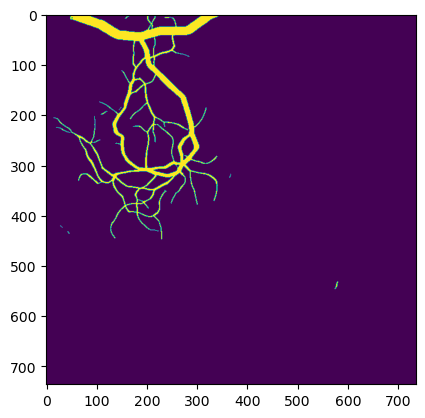

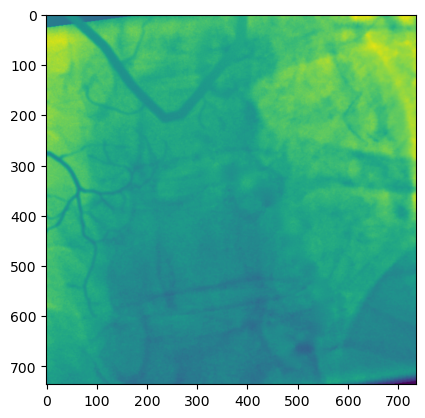

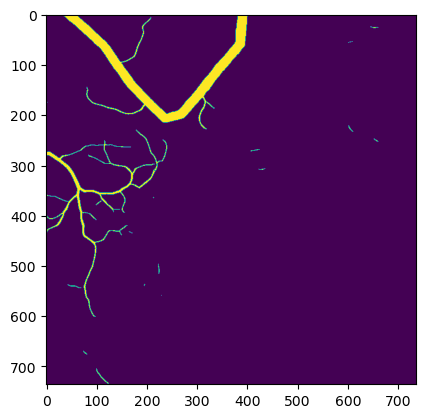

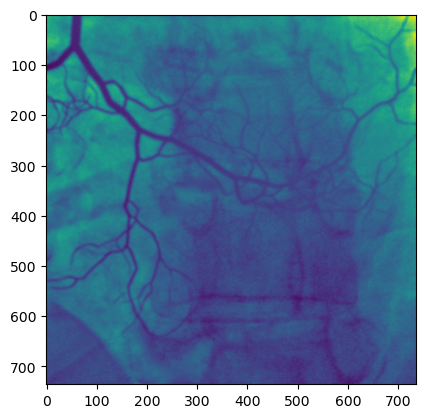

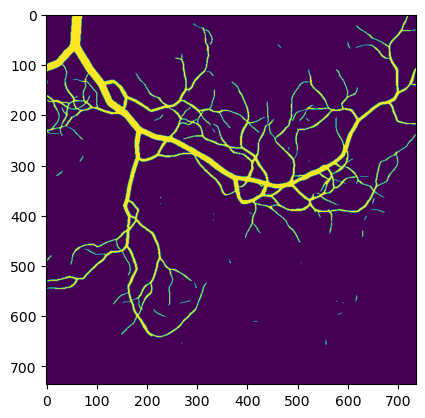

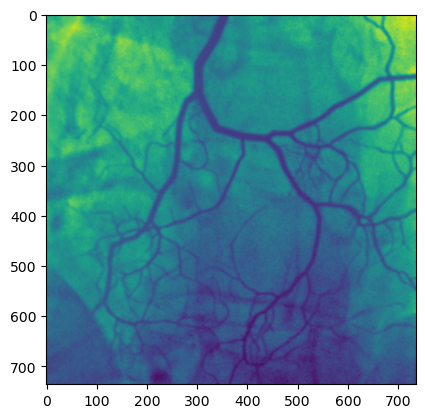

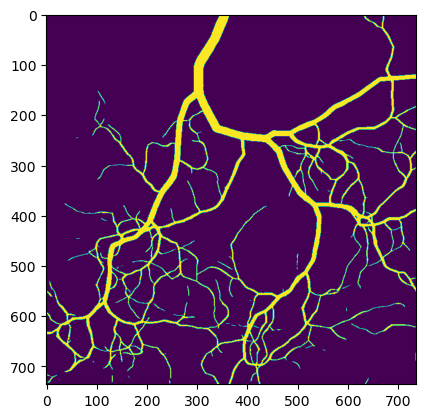

In [70]:
for idx, batch2 in enumerate(syn_test_loader):
        img, labels = batch2
        pred = model2(img.to(device).float())
        plt.imshow(img.numpy()[0][0])
        plt.show()
        pred = pred.sigmoid()
        pred = (pred > 0.9).float()
        plt.imshow(pred.detach().cpu().numpy()[0][0])
        plt.show()
        if idx == 10:
                break

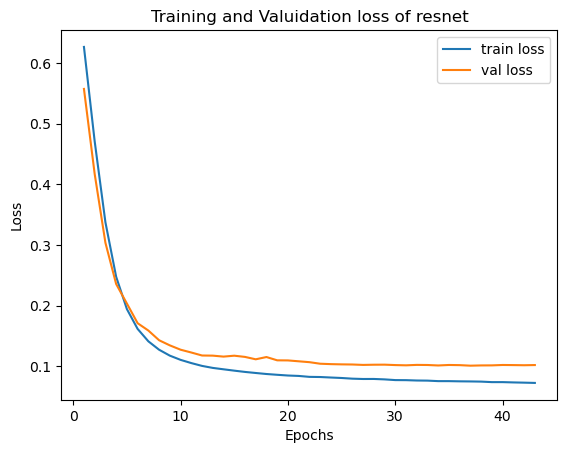

In [71]:
plt.plot(np.arange(len(losses))+1, losses, '-', label="train loss")
plt.plot(np.arange(len(losses))+1, val_losses, '-', label = "val loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Training and Valuidation loss of resnet")
plt.legend()
plt.show()

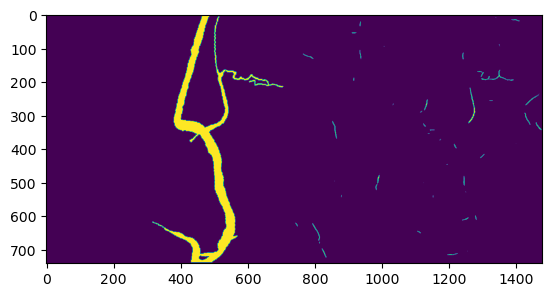

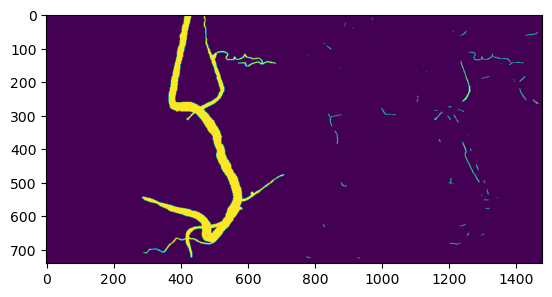

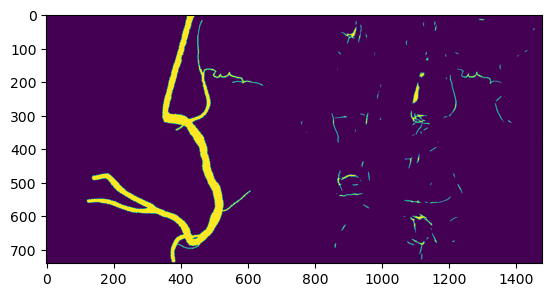

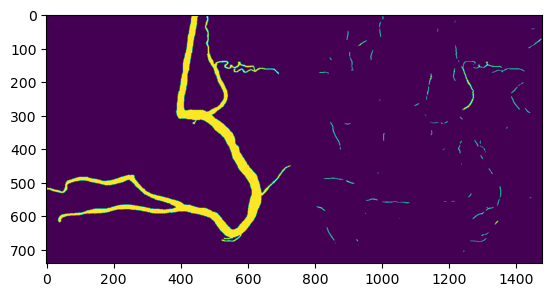

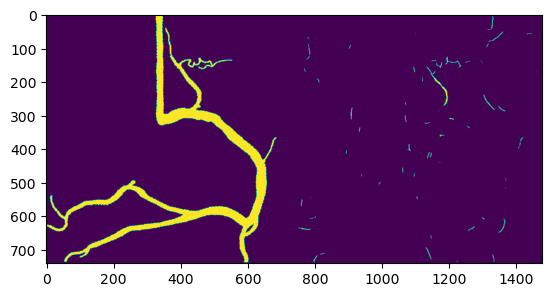

In [72]:
act_loader = td.DataLoader(act_test)
iter_act = iter(act_loader)

for i in range(5):
    img, lab = next(iter_act)
    pred = model2(img.to(device).float())
    pred = pred.sigmoid()
    predlab = torch.cat((lab, pred.detach().cpu()), dim=0)
    grid = torchvision.utils.make_grid(predlab)
    plt.imshow(grid.numpy()[0])
    plt.show()

In [73]:
#from torch.utils.data import DataLoader
#
#batch_size = 2
#
#syn_loader = DataLoader(
#  SynDataSet, 
#  batch_size = batch_size, 
#  num_workers=1)
#
#act_loader = DataLoader(
#  DataSetFull, 
#  batch_size = 1
#  )
#
#def batch_mean_and_sd(loader):
#    
#    cnt = 0
#    fst_moment = torch.empty(3)
#    snd_moment = torch.empty(3)
#
#    for images, _ in loader:
#        b, c, h, w = images.shape
#        nb_pixels = b * h * w
#        sum_ = torch.sum(images, dim=[0, 2, 3])
#        sum_of_square = torch.sum(images ** 2,
#                                  dim=[0, 2, 3])
#        fst_moment = (cnt * fst_moment + sum_) / (
#                      cnt + nb_pixels)
#        snd_moment = (cnt * snd_moment + sum_of_square) / (
#                            cnt + nb_pixels)
#        cnt += nb_pixels
#
#    mean, std = fst_moment, torch.sqrt(
#      snd_moment - fst_moment ** 2)        
#    return mean,std
#  
#syn_mean, syn_std = batch_mean_and_sd(syn_loader)
#print("mean and std {0}, {1}: \n".format(syn_mean.numpy()[0], syn_std.numpy()[0]))
#
#act_mean, act_std = batch_mean_and_sd(act_loader)
#print("mean and std: {0}, {1} \n".format(act_mean.numpy()[0], act_std.numpy()[0]))
#